## Prerequisites

gensim==3.6.0

In [13]:
from string import punctuation

import numpy as np
import pandas as pd 
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/train.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def preprocess_text(tokenizer, lemmatizer, stop_words, punctuation, text): 
    tokens = tokenizer(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return [token for token in lemmas if token not in stop_words and token not in punctuation and len(token) > 3 ]

df['cleaned'] = df.comment_text.apply(lambda x: preprocess_text(word_tokenize, lemmatizer, stop_words, punctuation, x))

In [0]:
df_sample = df.sample(100000)

In [17]:
df_sample.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned
84888,e326e84ac7d12af3,"Well, it has gone that far, actually I made t...",0,0,0,0,0,0,"[well, gone, actually, made, slip, writing, ur..."
147690,40434968e59e4ecc,This page is inaccurate \n\nIt actually said t...,0,0,0,0,0,0,"[page, inaccurate, actually, said, prior, 2002..."
1439,03d8889213604e8f,"On Sea World \n\nSorry mate, we're working out...",0,0,0,0,0,0,"[world, sorry, mate, working, kink, program, c..."
70644,bd12b3f4267549f7,Thank you. Have a great day.,0,0,0,0,0,0,"[thank, great]"
40921,6d34016874e06cdc,I LOVE SUCKING COCK! \n\nGIVE ME CUM OR GIVE ...,1,1,1,0,0,0,"[love, sucking, cock, give, give, death]"


### Train the model from scratch

Train our first model based on the vocabulary from df_sample: 

In [0]:
# With initialization model trained for 5 epochs 

model = Word2Vec(sentences=df_sample.cleaned.tolist(), 
         size=100,      # embedding vector size
         min_count=5,  # consider words that occured at least 5 times
         window=5)

In [19]:
# Continue training the model 

model.train(sentences=df_sample.cleaned.tolist(), 
            total_examples=model.corpus_count,
            epochs=30
           )

(82086744, 92431950)

In [0]:
#model.wv.vocab # to look at vocabulary 

In [21]:
model.most_similar('people')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('others', 0.5986545085906982),
 ('person', 0.5860205888748169),
 ('thing', 0.5674659013748169),
 ('everyone', 0.5372220277786255),
 ('anyone', 0.5272269248962402),
 ('editor', 0.5035445690155029),
 ('admins', 0.4985858201980591),
 ('dont', 0.49634140729904175),
 ('someone', 0.4886704385280609),
 ('individual', 0.48421967029571533)]

### The next approach is to try to use the already pretrained model, which can be downloaded from here:

https://github.com/RaRe-Technologies/gensim-data

model:   
GoogleNews-vectors-negative300.bin

In [22]:
model = KeyedVectors.load_word2vec_format("/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz", binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# You can try to use GloVe model too and experiment with it: 
#import gensim.downloader as api
#model = api.load('glove-wiki-gigaword-100')

## Words distance 

# 1 - Cosine similarity

To measure how similar two words are, we need a way to measure the degree of similarity between two embedding vectors for the two words. Given two vectors $u$ and $v$, cosine similarity is defined as follows: 

$$\text{CosineSimilarity(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

where $u.v$ is the dot product (or inner product) of two vectors, $||u||_2$ is the norm (or length) of the vector $u$, and $\theta$ is the angle between $u$ and $v$. This similarity depends on the angle between $u$ and $v$. If $u$ and $v$ are very similar, their cosine similarity will be close to 1; if they are dissimilar, the cosine similarity will take a smaller value. 

<img src="cosine_sim.png" style="width:800px;height:250px;">
<caption><center> **Figure 1**: The cosine of the angle between two vectors is a measure of how similar they are</center></caption>

**Exercise**: Implement the function `cosine_similarity()` to evaluate similarity between word vectors.

**Reminder**: The norm of $u$ is defined as $ ||u||_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$

In [0]:
def cosine_similarity(w1, w2):
    """
    Cosine similarity between w1 and w2
    
    Arguments:
        w1 : word vector        
        w2 : word vector 
    Returns:
        cosine_similarity 
    """
    if (not np.any(w1) or not np.any(w2)): # check input is not zero-vector
        return 0
    
    # Dot product between w1 and w2
    dot = np.dot(w1, w2)
    # L2 norm of w1
    norm_u = np.linalg.norm(w1) 
    # L2 norm of w2 
    norm_v = np.linalg.norm(w2) 
    # Cosine similarity 
    cosine_similarity = dot/(norm_u*norm_v)
    
    return cosine_similarity

In [25]:
father = model.get_vector("father")
mother = model.get_vector("mother")
ball = model.get_vector("ball")
crocodile = model.get_vector("crocodile")
france = model.get_vector("france")
italy = model.get_vector("italy")
kiev = model.get_vector("kiev")
ukraine = model.get_vector("ukraine")
paris = model.get_vector("paris")
rome = model.get_vector("rome")

print("cosine_similarity(father, mother) = ", cosine_similarity(father, mother))
print("cosine_similarity(ball, crocodile) = ",cosine_similarity(ball, crocodile))
print("cosine_similarity(france - paris, rome - italy) = ",cosine_similarity(france - paris, rome - italy))

cosine_similarity(father, mother) =  0.79014826
cosine_similarity(ball, crocodile) =  0.10283584
cosine_similarity(france - paris, rome - italy) =  -0.1988747


**Approximate expected output**:

<table>
    <tr>
        <td>
            **cosine_similarity(father, mother)** =
        </td>
        <td>
         0.79014826
        </td>
    </tr>
        <tr>
        <td>
            **cosine_similarity(ball, crocodile)** =
        </td>
        <td>
         0.10283585
        </td>
    </tr>
        <tr>
        <td>
            **cosine_similarity(france - paris, rome - italy)** =
        </td>
        <td>
         -0.421037
        </td>
    </tr>
</table>

## 2 - Word analogy task

In the word analogy task, we complete the sentence <font color='brown'>"*a* is to *b* as *c* is to **____**"</font>. An example is <font color='brown'> '*man* is to *woman* as *king* is to *queen*' </font>. In detail, we are trying to find a word *d*, such that the associated word vectors $e_a, e_b, e_c, e_d$ are related in the following manner: $e_b - e_a \approx e_d - e_c$. We will measure the similarity between $e_b - e_a$ and $e_d - e_c$ using cosine similarity. 

**Exercise**: Complete the code below to be able to perform word analogies!

***Note***: here you will need to complete a function in the sections, which are marked as:

```
# ----- Start ----- #
Your code should be written in-between the lines
# ------ End ------ #
```


In [0]:
def find_word_analogy(word_1, word_2, word_3, model):
    """
    Finds the word to complete analogy (see explanation above): a is to b as c is to ____. 
    
    Arguments:
    word_1 -- a word, string
    word_2 -- a word, string
    word_3 -- a word, string
    model -- word embeddings model 
    
    Returns:
    best_word --  the word such that v_1 - v_2 is close to v_best_word - v_3, as measured by cosine similarity
    """
    
    # convert words to lower case
    word_1, word_2, word_3 = word_1.lower(), word_2.lower(), word_3.lower()
    
    # ----- Start ----- #
    # Get the word embeddings v_a, v_b and v_c (≈1-3 lines)
    e_1, e_2, e_3 = [model.get_vector(x) for x in [word_1, word_2, word_3]]
    # ------ End ------ #
    
    words = list(model.vocab.keys())
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None

    # Loop over the whole word vector set
    for w in words:  
        e_j = model.get_vector(w)      
        # to avoid best_word being one of the input words, skip them and continue iteration.
        if w in [word_1, word_2, word_3] :
            continue
        
        # ----- Start ----- #
        # Compute cosine similarity between the vector (e_2 - e_1) and the vector ((w's vector) - e_3)
        cosine_sim = cosine_similarity(e_2 - e_1, e_j - e_3)
        
        # If the cosine_sim is more than the max_cosine_sim seen so far,
        # do not forget to set new max_cosine_sim to the current value and best_word as well
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        # ------ End ------ #
        
    return best_word

In [27]:
triads_to_try = [('man', 'woman', 'king'), ('bad', 'good', 'sad'), ('man', 'woman', 'boy'), ('small', 'smaller', 'large')]
for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, find_word_analogy(*triad,model)))

man -> woman :: king -> queen
bad -> good :: sad -> wonderful
man -> woman :: boy -> girl
small -> smaller :: large -> larger


**Expected Output**:

<table>
    <tr>
        <td>
            **man -> woman** ::
        </td>
        <td>
         king -> queen
        </td>
    </tr>
        <tr>
        <td>
            **bad -> good** ::
        </td>
        <td>
         sad -> wonderful
        </td>
    </tr>
        <tr>
        <td>
            **man -> woman ** ::
        </td>
        <td>
         boy -> girl
        </td>
    </tr>
        <tr>
        <td>
            **small -> smaller ** ::
        </td>
        <td>
         large -> larger
        </td>
    </tr>
</table>

#### The next part of the task is to:  

1. Train your own W2V model using the proposed method above. Use all of the tokens created after your preprocessing pipeline in the previous tasks. (deleting stop_words, punctuation, lowercasing, etc - play as you want).  
2. Use obtained vectors to obtain text vectors using such pipeline: 
  1. For each word in a preprocessed text, get a word vector from the W2V model. 
  2. Add them together to obtain vectors for texts (sum them together, or get mean vector) 
3. Use obtained text vectors as a text representation to perform a text classification task.  
   Proposed - use binary classification (for example: select only 'obscene' text and clean and try to distinguish them one from another)
4. Calculate the metrics - TP, FP, FN, TN, precision, recall, F1 score, F2 score, accurary. 


In [0]:
def preprocess_text(tokenizer, lemmatizer, stop_words, punctuation, text): 
    tokens = tokenizer(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return [token for token in lemmas if token not in stop_words and token not in punctuation and len(token) > 4 and len(token) < 20]

df['cleaned'] = df.comment_text.apply(lambda x: preprocess_text(word_tokenize, lemmatizer, stop_words, punctuation, x))
df_sample = df.sample(100000)

In [50]:
model = Word2Vec(sentences=df_sample.cleaned.tolist(), 
         size=300,
         min_count=10,
         window=5)

model.train(sentences=df_sample.cleaned.tolist(), 
            total_examples=model.corpus_count,
            epochs=40
           )

(80312063, 94525600)

In [51]:
from scipy.sparse import lil_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

def flat_nested(nested):
    flatten = []
    for item in nested:
        if isinstance(item, list):
            flatten.extend(item)
        else:
            flatten.append(item)
    return flatten


def get_vectors(series, model, weighted):
    dim = len(model.wv['token'])
    vectors = lil_matrix((series.size, dim))
    if weighted == 0:
        for i in range(series.size):
            text = series.iloc[i]
            vec = np.zeros(dim)
            for token in text:
                try:
                    vec += model.wv[token]
                except KeyError:
                    continue
            vectors[i] = vec
    else:
        cnt = Counter(flat_nested(series.apply(lambda x: list(set(x))).tolist()))
        for i in range(series.size):
            text = series.iloc[i]
            vec = np.zeros(dim)
            for token in text:
                try:
                    tf = float(text.count(token))/len(text)
                    d = cnt[token]
                    vec += model.wv[token]*tf*(np.log(float(1+series.size)/(1+d))+1)
                except KeyError:
                    continue
            vectors[i] = vec

    return vectors

def score(pred,y):
    TN = np.sum([(pred==y) & (y == 0)]) 
    TP = np.sum([(pred==y) & (y == 1)])
    
    FN = np.sum([(pred!=y) & (y == 1)])
    FP = np.sum([(pred!=y) & (y == 0)])

    return TN, TP, FN, FP

def score_2(pred,y):
    TN, TP, FN, FP = score(pred,y)
    prec = TP/(FP+TP)
    rec = TP/(TP+FN)
    F1 = 2*TP/(2*TP + FP + FN)
    F2 = 5*prec*rec/(4*prec + rec)
    acc = (TP +TN)/(TN + TP + FN + FP)
    lst = np.around([prec, rec, F1, F2, acc], decimals=2)
    names = ['prec', 'rec', 'F1', 'F2', 'acc']
    return dict(zip(names, lst))

def print_scores(pred, y_test):
    categories = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
    mean = np.zeros(5)
    for i in range(6):
        print(categories[i], ':', score_2(pred.T[i], y_test.T[i]))
        mean += np.array(list(score_2(pred.T[i], y_test.T[i]).values()))
    return mean/6

def fit_and_predict_knn(df, w2v_model, weighted):
    train, test = train_test_split(df, random_state=1, test_size=0.25)
    categories = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

    x_train = get_vectors(train['cleaned'], w2v_model,  weighted).toarray()
    x_test = get_vectors(test['cleaned'], w2v_model, weighted).toarray()
    y_train = train[categories].values
    y_test = test[categories].values

    classifier = RandomForestClassifier()
    classifier.fit(x_train,y_train)
    predictions = classifier.predict(x_test)

    scores = print_scores(predictions, y_test)

    return predictions, scores

preds_0, scores_0 = fit_and_predict_knn(df, model, 0)

toxic : {'prec': 0.85, 'rec': 0.29, 'F1': 0.43, 'F2': 0.33, 'acc': 0.93}
severe_toxic : {'prec': 0.44, 'rec': 0.08, 'F1': 0.13, 'F2': 0.09, 'acc': 0.99}
obscene : {'prec': 0.84, 'rec': 0.27, 'F1': 0.41, 'F2': 0.31, 'acc': 0.96}
threat : {'prec': 0.38, 'rec': 0.02, 'F1': 0.04, 'F2': 0.03, 'acc': 1.0}
insult : {'prec': 0.8, 'rec': 0.26, 'F1': 0.39, 'F2': 0.3, 'acc': 0.96}
identity_hate : {'prec': 0.52, 'rec': 0.06, 'F1': 0.1, 'F2': 0.07, 'acc': 0.99}


#### The second part of the task is: 

1. While performing a step 2 for text vectorization, for each word add its vector with tf-idf weight -> weighted average. 
2. Perform a same text classification task as it was required above. 
3. Calculate the metrics, compare with a vectorization approach without weightning. 

In [52]:
preds_1, scores_1 = fit_and_predict_knn(df, model, 1)

toxic : {'prec': 0.82, 'rec': 0.28, 'F1': 0.41, 'F2': 0.32, 'acc': 0.92}
severe_toxic : {'prec': 0.51, 'rec': 0.08, 'F1': 0.13, 'F2': 0.09, 'acc': 0.99}
obscene : {'prec': 0.83, 'rec': 0.26, 'F1': 0.4, 'F2': 0.31, 'acc': 0.96}
threat : {'prec': 0.22, 'rec': 0.02, 'F1': 0.03, 'F2': 0.02, 'acc': 1.0}
insult : {'prec': 0.78, 'rec': 0.25, 'F1': 0.38, 'F2': 0.29, 'acc': 0.96}
identity_hate : {'prec': 0.54, 'rec': 0.07, 'F1': 0.12, 'F2': 0.08, 'acc': 0.99}


#### The third part of the task is: 

1. Use a pre-trained W2V model for obtaining a word vectors for each of the tokens in your dataset, create text vectors WITHOUT weightning. 
2. Train text classification model.
3. Calculate the metrics.

In [53]:
model = KeyedVectors.load_word2vec_format("/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz", binary=True)
preds_2, scores_2 = fit_and_predict_knn(df, model, 0)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


toxic : {'prec': 0.86, 'rec': 0.23, 'F1': 0.37, 'F2': 0.27, 'acc': 0.92}
severe_toxic : {'prec': 0.4, 'rec': 0.07, 'F1': 0.12, 'F2': 0.08, 'acc': 0.99}
obscene : {'prec': 0.84, 'rec': 0.22, 'F1': 0.36, 'F2': 0.26, 'acc': 0.96}
threat : {'prec': 0.44, 'rec': 0.03, 'F1': 0.06, 'F2': 0.04, 'acc': 1.0}
insult : {'prec': 0.79, 'rec': 0.21, 'F1': 0.33, 'F2': 0.25, 'acc': 0.96}
identity_hate : {'prec': 0.53, 'rec': 0.05, 'F1': 0.1, 'F2': 0.07, 'acc': 0.99}


#### The fourth part of the task is: 

1. Use a pre-trained W2V model for obtaining a word vectors for each of the tokens in your dataset, create text vectors WITH tf-idf weightning. 
2. Train a text classification model. 
3. Calculate the metrics. 

In [54]:
preds_3, scores_3 = fit_and_predict_knn(df, model, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


toxic : {'prec': 0.8, 'rec': 0.23, 'F1': 0.36, 'F2': 0.27, 'acc': 0.92}
severe_toxic : {'prec': 0.45, 'rec': 0.06, 'F1': 0.11, 'F2': 0.08, 'acc': 0.99}
obscene : {'prec': 0.86, 'rec': 0.22, 'F1': 0.35, 'F2': 0.26, 'acc': 0.96}
threat : {'prec': 0.33, 'rec': 0.02, 'F1': 0.04, 'F2': 0.03, 'acc': 1.0}
insult : {'prec': 0.78, 'rec': 0.21, 'F1': 0.33, 'F2': 0.24, 'acc': 0.96}
identity_hate : {'prec': 0.57, 'rec': 0.07, 'F1': 0.12, 'F2': 0.08, 'acc': 0.99}


### Visualizations part 

Use dimentionality reduction methods such as t-SNE or PCA to make your 300 dim vectors available for 2D plotting. 

Select top (10-20) words for each cathegory BY TF-IDF SCORE, not counts!!! 

Plot on the ONE plot all of this words but colors must be different for top-words for obscene cathegory, clean, toxic, etc... 

See, if words from one cathegory are closer to each other than to others. 
Or you observe ~2 clusters: all of the toxic words, clean words.  
Explain what you see and why. 


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use s

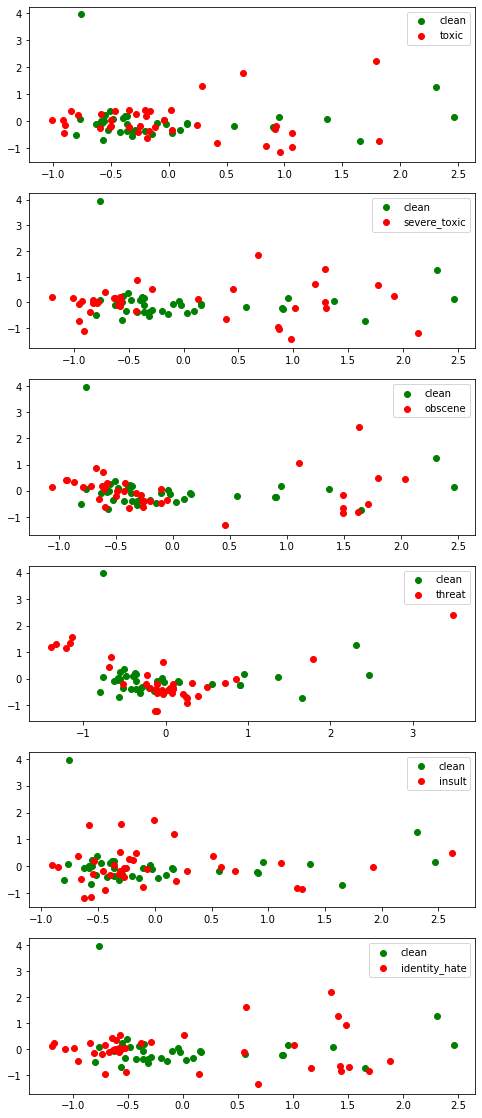

In [58]:
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

model = KeyedVectors.load_word2vec_format("/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz", binary=True)
categories = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

def flat_nested(nested):
    flatten = []
    for item in nested:
        if isinstance(item, list):
            flatten.extend(item)
        else:
            flatten.append(item)
    return flatten

def get_top(category, sample_size, df, model):

    temp = pd.DataFrame(df.sample(sample_size))
    if category == 0: 
        for c in categories:
            temp = temp[temp[c] == 0]
    else:
        temp = temp[temp[category] != 0]
    cnt_vocab = Counter(flat_nested(temp.cleaned.tolist()))
    cleaned_vocab = [token for token, count in cnt_vocab.items() if count > 10 and len(token) > 4 and len(token) < 20]  

    vectorizer = TfidfVectorizer(vocabulary = cleaned_vocab)
    pca = PCA(n_components=2)

    tfidf = vectorizer.fit_transform(temp.cleaned.str.join(' '))
    feature_array = np.array(vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(tfidf.toarray()).flatten()[::-1]

    top_40 = feature_array[tfidf_sorting][:40]
    del tfidf, tfidf_sorting, feature_array

    vecs = []
    for token in top_40:
        try:
            vecs.append(model.wv[token])
        except:
            continue    
    vecs = np.array(vecs)
    pca.fit(vecs)
    vecs = pca.transform(vecs)
    return vecs
vecs =  get_top(0, 20000, df, model)


fig, axes = plt.subplots(6, figsize=(8,20))

for i in range(6):
    c = categories[i]
    vecs1 =  get_top(c, 100000, df, model)
    axes[i].scatter(vecs.T[0],vecs.T[1], c = 'green', label = 'clean')
    axes[i].scatter(vecs1.T[0],vecs1.T[1], c = 'red', label = c)
    axes[i].legend()

plt.show()

We can see that toxic and clean comments are stacked in different clusters. 
This behavior is due to the fact that exists difference beetween word classes.  

### Additional part: 

1. Find a pre-trained FastText vetors, understand it's difference from W2V vectors. 
2. Vectorize all of your texts using FT model, perform a text classification, calculate the metrics, compare with W2V approach. 

Or/And you can:

1. Train your own FT model and make the same. 
2. Compare it with previous approaches.

In [0]:
### Your code here 

### Conclusions: 

Please, provide a clear table or dataframe with all of the metrics for all of the trained/used models available.   

Compare them to each other.   

Make conclusions which one from your models worked better for this particular task.   
BE CAREFUL: Having a better model performance on this particular task does not matter that this model is better than others in GENERAL. You need to make your own conclusions about this particular model applied to this particular task. Please, think and understand WHY.   
Write your thoughts down below: 



In [57]:
metr = ['prec', 'rec', 'F1', 'F2', 'acc']
cols = ['metric','trained_from_scratch_not_weighted', 'trained_from_scratch_weighted', 'pretrained_not_weigted', 'pretrained_weigted']
arr = np.array([metr,scores_0,scores_1,scores_2,scores_3])
res = pd.DataFrame(dict(zip(cols,arr)))
res[cols[1:]] = res[cols[1:]].astype('float').round(2)
res

,metric,trained_from_scratch_not_weighted,trained_from_scratch_weighted,pretrained_not_weigted,pretrained_weigted
0,prec,0.64,0.62,0.64,0.63
1,rec,0.16,0.16,0.14,0.14
2,F1,0.25,0.25,0.22,0.22
3,F2,0.19,0.19,0.16,0.16
4,acc,0.97,0.97,0.97,0.97


All models worked nearly the same, high accuracy with low precision and recall. Of course, if one model works good for one task, that doesn't mean that it will work properly for another task, in each task scientist have to analyse dataset and make proper decisions with making features. 